# Final project

Bottle cap detection

In [2]:
import cv2
# from sklearn.cluster import KMeans
import numpy as np
import math
from matplotlib import pyplot as plt

In [18]:
# select one of these files
# imgname = "black1.jpg"
# imgname = "black2.jpg"
imgname = "black10.jpg"
# imgname = "black4.png"
# imgname = "black5.jpg"
# imgname = "black6.png"
# read the image and resize
img = cv2.imread(imgname)
scale_factor = min(1024 / img.shape[0], 768 / img.shape[1], 1)
img = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## Image segmentation

* second approach, based on edges.

Detect edges on the graph. Use morphological closing to create bounding contours.

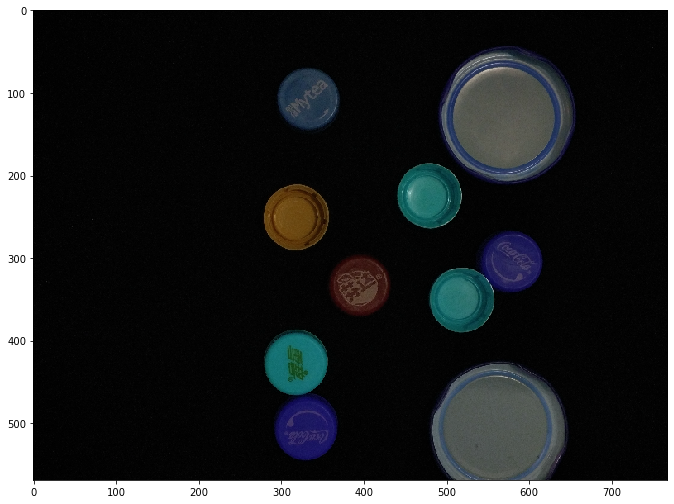

In [19]:
edge_threshold = 10
edeg_threahold_max = 2.5 * edge_threshold

blurred = cv2.medianBlur(gray, 3)
# blurred = gray.copy()
edges = cv2.Canny(blurred, edge_threshold, edeg_threahold_max, apertureSize=3)
fig = plt.figure(figsize=(25,20))
fig.add_subplot(1,2,1)
plt.imshow(img)

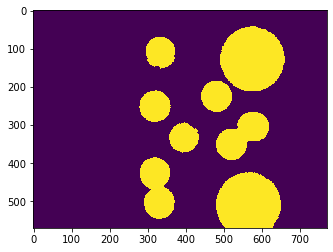

In [20]:
# apply morph operations, construct SCCs and floodfill the result.
# Then apply watershed iteratively until cap count is reached

struct_ele = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
edges_closed = edges.copy()
edges_closed = cv2.morphologyEx(edges_closed, cv2.MORPH_DILATE, struct_ele, iterations=1)
edges_closed = cv2.morphologyEx(edges_closed, cv2.MORPH_CLOSE, struct_ele, iterations=5)
# ret, edges_closed = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_OTSU)
# print(ret)
mask = np.zeros((edges_closed.shape[0] + 2, edges_closed.shape[1] + 2), dtype="uint8")
cv2.floodFill(edges_closed, mask, (0,0), 255, flags=cv2.FLOODFILL_MASK_ONLY)[1]
mask[...] = 255 * (1 - mask)

# fill the mask
# ctrs, h = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# print(len(ctrs))

cap_cnt = 10
def get_markers(mask_orig):
    mask = mask_orig.copy()
    cnt = 0
    result = []
    while cnt < cap_cnt:
        mask = cv2.medianBlur(mask, 9)
        # do distance transform
        dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
        dist = dist.astype("uint8")
        ret, markers_binary = cv2.threshold(dist, 0.7 * dist.max(), 255, 0)
        # do marker labelling
        ret, markers = cv2.connectedComponents(markers_binary)
        cur_cnt = markers.max()
        print("Got", cur_cnt, "marker(s)")
        cnt += cur_cnt
        cur_result = []
        for i in range(1, cur_cnt + 1):
            pos = np.nonzero(markers == i)
            x, y = pos[1], pos[0]
            minx, maxx, miny, maxy = x.min(), x.max(), y.min(), y.max()
            w = np.max(dist[markers == i])
            cur_result.append(((minx, miny), (maxx, maxy), w))
        result.extend(cur_result)
        if cnt < cap_cnt:
            for i in range(cur_cnt):
                (minx, miny), (maxx, maxy), w = cur_result[i]
                radius = w + 20 # just in case :)
                print("Removing", (minx, miny), (maxx, maxy), radius)
                mask = cv2.circle(mask, ((minx + maxx)//2, (miny+maxy)//2), radius, 0, -1)
        elif cnt > cap_cnt:
            # this is not what we expect, but it can happen
            # you'll need to fine tune the results here
            print("warning: 翻车啦")
    return result

plt.imshow(mask)

Got 2 marker(s)
Removing (547, 101) (601, 155) 102
Removing (537, 482) (592, 512) 92
Got 8 marker(s)


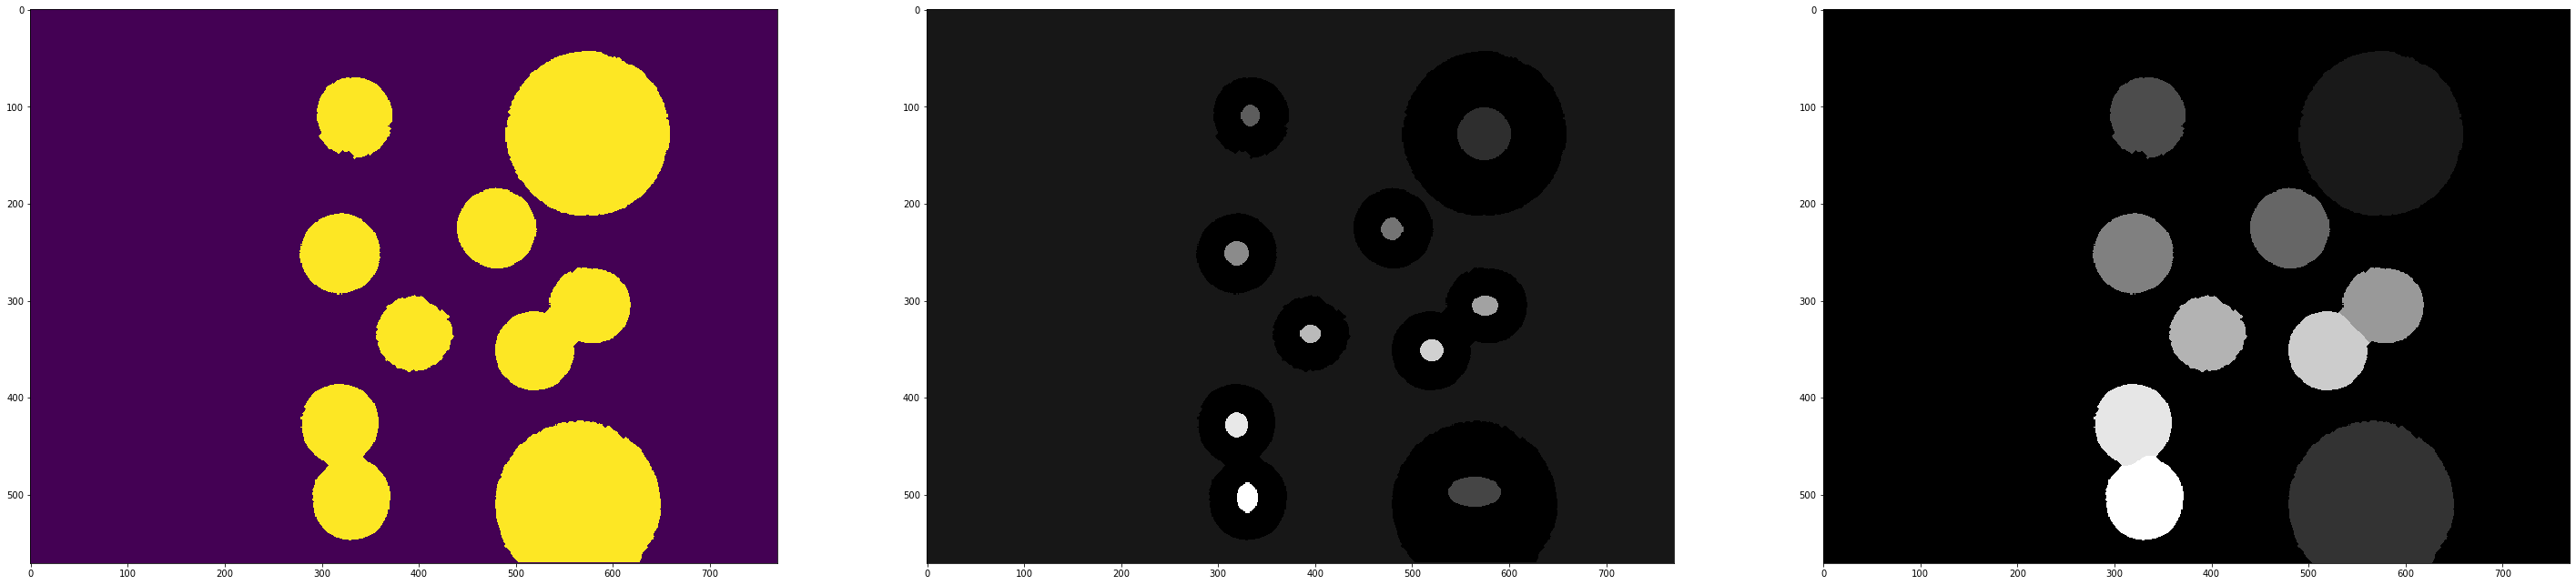

In [21]:
markers = get_markers(mask)
# now prepare for watersheding
ws = np.logical_not(mask).astype('int32')
for i, (p1, p2, w) in enumerate(markers):
    center = (p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2
    axis = ((p2[0] - p1[0]) // 2, (p2[1] - p1[1]) // 2)
    cv2.ellipse(ws, center, axis, 0, 0, 360, i+2, cv2.FILLED)
    # cv2.rectangle(ws, p1, p2, i+2, cv2.FILLED)
flooded = ws.copy()
flooded = cv2.watershed(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), flooded)
flooded[...] = flooded - 1
flooded[flooded <= 0] = 0
# dilate a little to remove tiny edges
flooded = flooded.astype("uint8")
flooded = cv2.morphologyEx(flooded, cv2.MORPH_DILATE, struct_ele, iterations=1)
fig = plt.figure(figsize=(50, 20))
fig.add_subplot(1,3,1)
plt.imshow(mask)
fig.add_subplot(1,3,2)
plt.imshow(ws, cmap="gray")
fig.add_subplot(1,3,3)
plt.imshow(flooded, cmap="gray")

# markers_binary[centers] = 255
# find unsure region

# # Marker labelling
# ret, markers = cv2.connectedComponents(markers_binary)
# # Add one to all labels so that sure background is not 0, but 1
# markers = markers+1
# # Now, mark the region of unknown with zero
# # markers[unknown == 255] = 0
ws = flooded

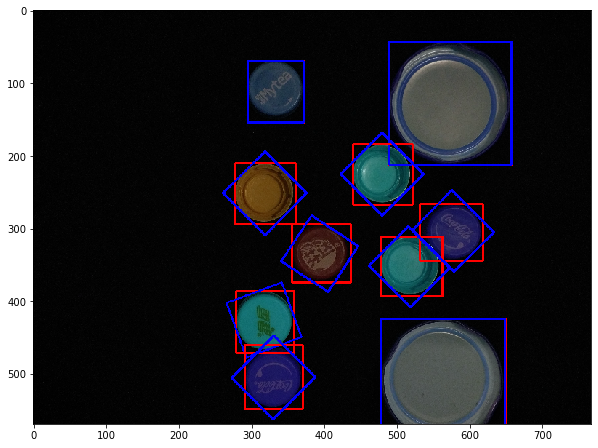

In [22]:
# find bounding boxes & minimal bounding boxes
boxed = img.copy()
bounding_boxes = []
minimal_bounding_boxes = []
for i in range(cap_cnt):
    # value in marker image is i+1
    buf = (ws == i + 1).astype('uint8')
    # use this in OpenCV 3.x
    # tmpimage,contours, hierarchy = cv2.findContours(buf, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # use this in OpenCV 4.x
    contours, hierarchy = cv2.findContours(buf, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    assert(len(contours) == 1)
    x, y, w, h = cv2.boundingRect(contours[0])
    bounding_boxes.append(((x, y), (x + w, y + h)))
    minimal_bounding_boxes.append(cv2.minAreaRect(contours[0]))
    box_points = cv2.boxPoints(minimal_bounding_boxes[-1])
    box_points = np.int0(box_points)
    cv2.rectangle(boxed, bounding_boxes[-1][0], bounding_boxes[-1][1], (255, 0, 0), 2)
    cv2.drawContours(boxed, [box_points], 0, (0, 0, 255), 2)

fig = plt.figure(figsize=(10, 10))
plt.imshow(boxed)

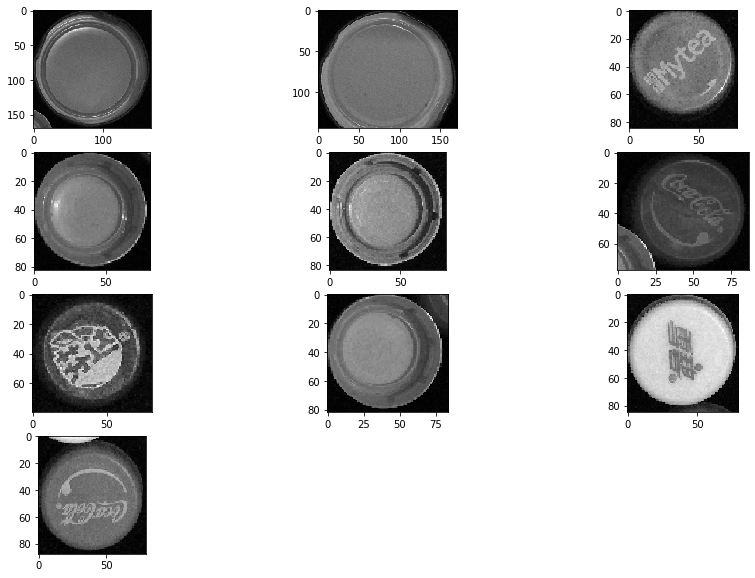

In [26]:
# do the actual segmentation
# rule out the thin ones - they are considered "sides"
real_caps = []
cap_edges = []
real_ans = []
edges = cv2.Canny(img, 40, 80)
for i, ((p1, p2), (center, (width, height), a)) in enumerate(zip(bounding_boxes, minimal_bounding_boxes)):
    real_caps.append(gray[p1[1]:p2[1], p1[0]:p2[0]])
    cap_edges.append(edges[p1[1]:p2[1], p1[0]:p2[0]])
    if width / height > 1.5 or height / width > 1.5:
        print(i, "This is a side")
        real_ans.append('side')
    else:
        real_ans.append(None)

fig = plt.figure(figsize=(15,10))
k = len(real_caps)
for i, pic in enumerate(real_caps):
    fig.add_subplot((k + 2) // 3, 3, i + 1)
    plt.imshow(pic, cmap="gray")

## Determining head or tail

* Approach one: Calculate density of edges in the center area of the cap picture. Head(with brand icons) tend to have more edges.
* Approach two: Use SURF to match the brand icons.

We combine the two approaches here to get the best results.

0
0
0
0
107730
12
1280
0
0
0
80230
3
162689
17
4513
0
143817
31
78798
2


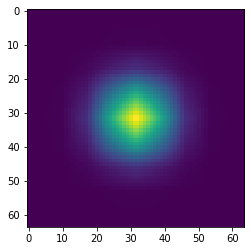

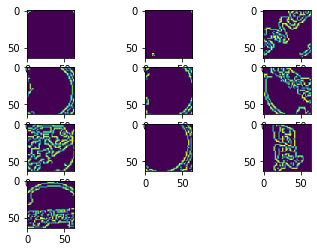

In [27]:
# get two-dimension gaussian kernel
t = cv2.getGaussianKernel(9, 1)
gaussian_kernel = t * t.T
gaussian_kernel *= 255 / np.max(gaussian_kernel)
gaussian_kernel = np.uint8(gaussian_kernel)
gaussian_kernel = cv2.resize(gaussian_kernel, (64, 64))
plt.imshow(gaussian_kernel)
fig = plt.figure()

surf=cv2.xfeatures2d.SURF_create()
bf=cv2.BFMatcher()
for no, (cap, edge) in enumerate(zip(real_caps, cap_edges)):
    if real_ans[no] is not None:
        print("Skipping", no, "it is a side")
        continue
    normal_detect=0
    surf_detect=0
    
    # Approach one
    c = cv2.resize(cap, (128, 128))
    e = cv2.resize(edge, (128, 128))
    rx, ry = c.shape[0] // 4, c.shape[1] // 4
    cx, cy = c.shape[0] // 2, c.shape[1] // 2
    fig.add_subplot((len(real_caps) + 2) // 3, 3, no + 1)
    plt.imshow(e[cx-rx:cx+rx , cy-ry:cy+ry])
    score = np.sum(e[cx-rx:cx+rx , cy-ry:cy+ry] * gaussian_kernel)
    print(score)
    if score > 50000:
        normal_detect=1
        
    # Approach two
    resizecap=cv2.resize(cap,(400,400))
    resizecap=resizecap[150:-150,150:-150]
    #resizecap=cv2.Canny(resizecap,10,100)
    kp, des = surf.detectAndCompute(resizecap, None)
    if des is None:
        print(0)
        score=0
    else:
        score=len(des)
        print(score)
    if score > 0:
        surf_detect=1
    
    if normal_detect==surf_detect:
        real_ans[no] = 'top'if surf_detect>0 else "tail"
    else:
        real_ans[no] = 'top'if normal_detect>0 else "tail"
#       real_ans[no]="unknown"
    


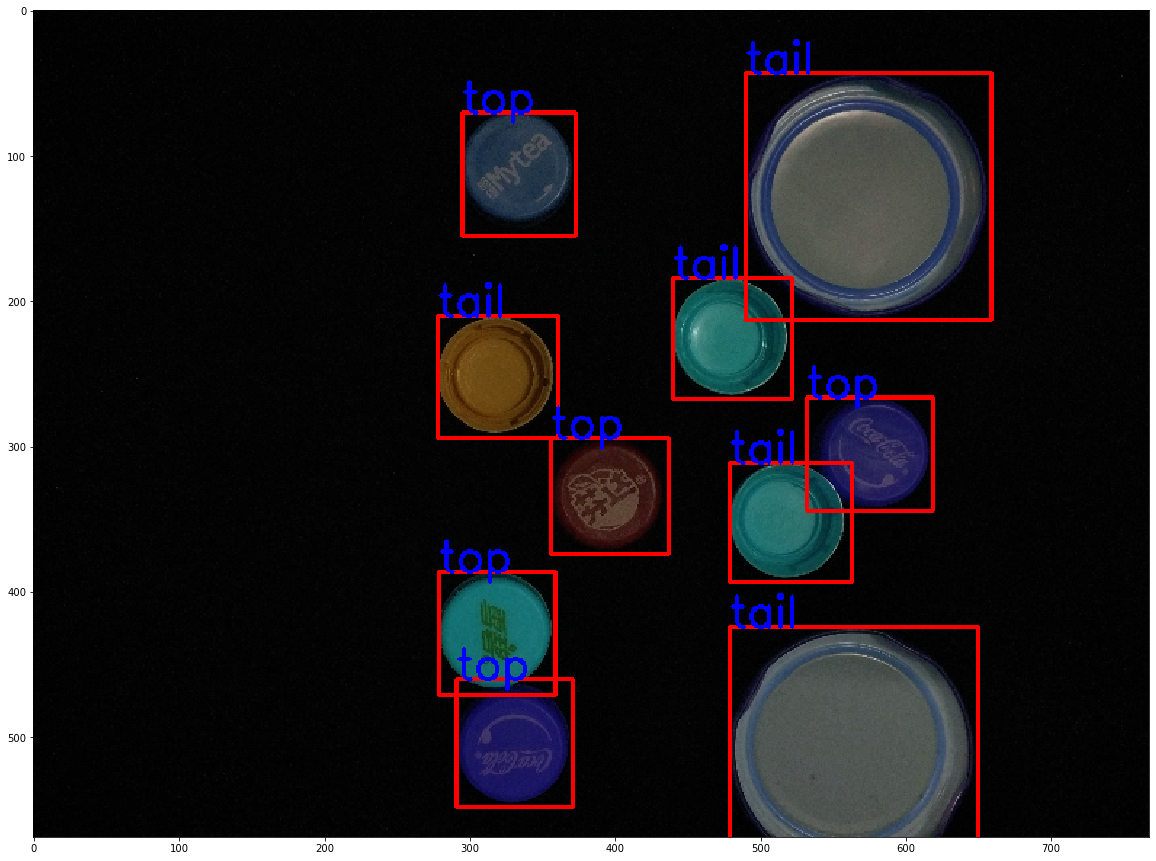

In [29]:
# draw the results.
labelled = img.copy()
for i in range(len(real_ans)):
    cv2.rectangle(labelled, bounding_boxes[i][0], bounding_boxes[i][1], (255,0,0), 2)
    cv2.putText(labelled, real_ans[i], bounding_boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

fig = plt.figure(figsize=(20,20))
plt.imshow(labelled)

## Image segmentation

* First approach, use HSV thresholding.

Convert into HSV space and threshold on the saturation value.

Very promising results with colored caps, not so effective with black/white caps. This approach is abadoned.

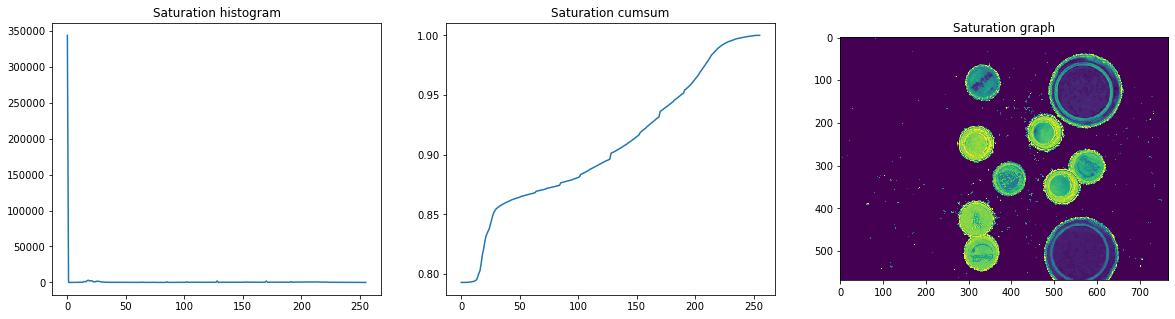

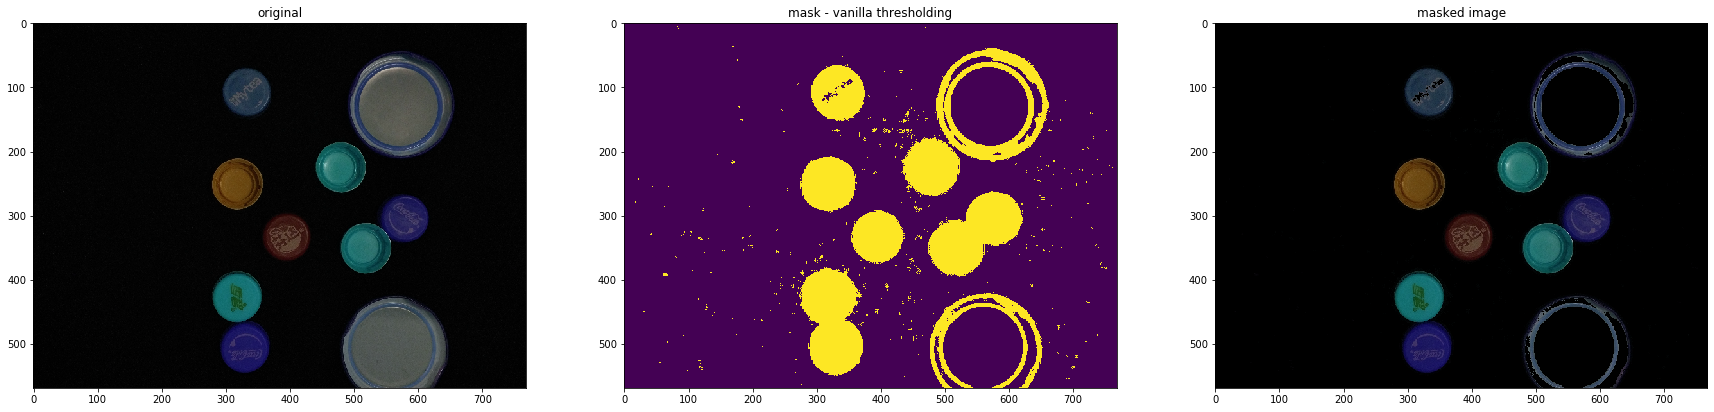

In [30]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# use saturation thresholding
threshold, binary = cv2.threshold(hsv[:, :, 1], 40, 255, cv2.THRESH_BINARY)

fig = plt.figure(figsize=(20,5))
hist = cv2.calcHist([hsv], [1], None, [256], [0,255])
cs = np.cumsum(hist)
cs /= cs[-1]
fig.add_subplot(1,3,1)
plt.title("Saturation histogram")
plt.plot(hist)
fig.add_subplot(1,3,2)
plt.title("Saturation cumsum")
plt.plot(cs)
fig.add_subplot(1,3,3)
plt.title("Saturation graph")
plt.imshow(hsv[:,:,1])

fig = plt.figure(figsize=(30,10))
fig.add_subplot(1,3,1)
plt.title("original")
plt.imshow(img)
fig.add_subplot(1,3,2)
plt.title("mask - vanilla thresholding")
plt.imshow(binary)
fig.add_subplot(1,3,3)
plt.title("masked image")
plt.imshow(cv2.bitwise_and(img, img, mask=binary))

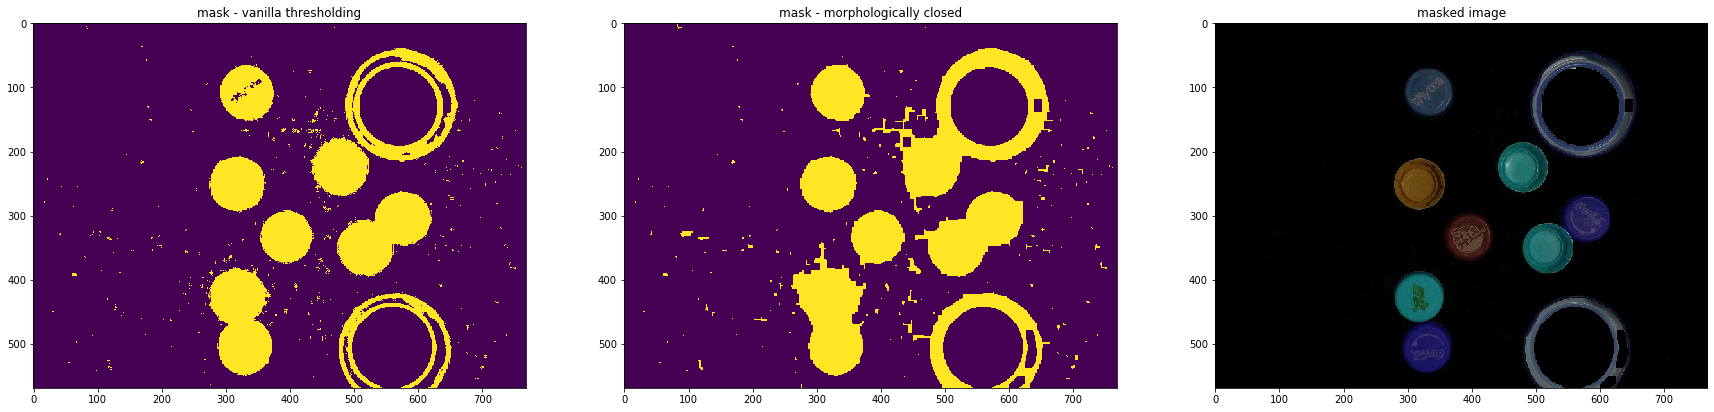

In [31]:
# fine tune the binary mask
# use morphological closing

struct_ele = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, struct_ele, iterations=5)

fig = plt.figure(figsize=(30, 20))
fig.add_subplot(1,3,1)
plt.title("mask - vanilla thresholding")
plt.imshow(binary)
fig.add_subplot(1,3,2)
plt.title("mask - morphologically closed")
plt.imshow(closed)
fig.add_subplot(1,3,3)
plt.title("masked image")
plt.imshow(cv2.bitwise_and(img, img, mask=closed))
# morphological op to get accurate mask